
📅 Future 8 Weeks Forecast for DESWIN  TAB:
       Week  Predicted_Quantity
0  2025-W43                  37
1  2025-W44                  36
2  2025-W45                  34
3  2025-W46                  34
4  2025-W47                  33
5  2025-W48                  34
6  2025-W49                  36
7  2025-W50                  36


C:\Users\Strix\AppData\Local\Temp\ipykernel_35644\3646408082.py:119: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Strix\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


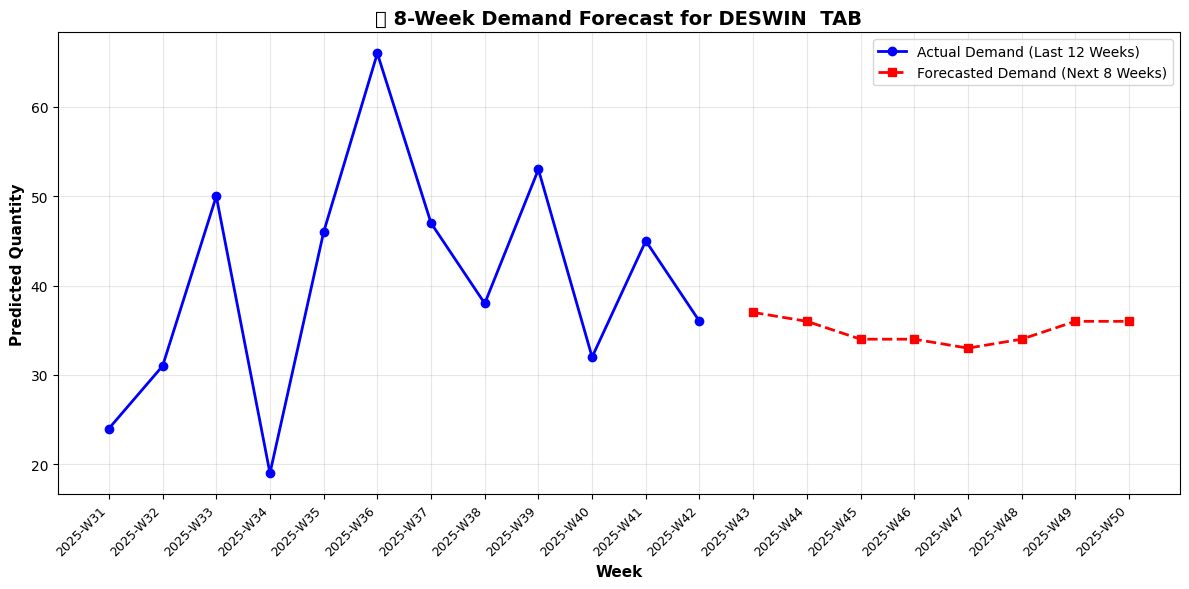

C:\Users\Strix\AppData\Local\Temp\ipykernel_35644\3646408082.py:142: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Strix\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


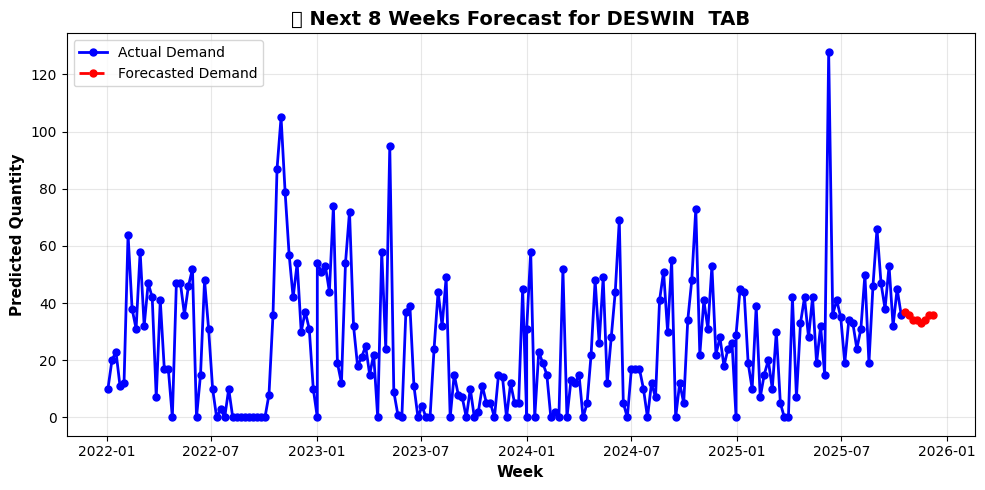


💾 Forecast saved to '../outputs/forecast_DESWIN__TAB_8weeks_LSTM.xlsx'


In [11]:
# =============================================
# 📦 LSTM Demand Forecasting (Final Combined Version)
# =============================================

import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime as dt
import os

# ===============================
# 1️⃣ Load trained model & data
# ===============================

# Load dataset
file_path = r"C:\Users\Strix\Desktop\Boehm Tech\demand forecasting\data\demand_prediction_weekly.xlsx"
sales_data = pd.read_excel(file_path)

# User selects medicine
medicine_name = input("Enter the medicine name: ")

# Load LSTM model
model_dir = r"C:\Users\Strix\Desktop\Boehm Tech\demand forecasting\saved models"
model_path = os.path.join(model_dir, f"LSTM_{medicine_name}.keras")
model = load_model(model_path)

# ===============================
# 2️⃣ Filter data for the medicine
# ===============================
product_df = sales_data[sales_data['Product_Name'] == medicine_name].copy()
product_df = product_df.groupby('Week')['Total_Quantity'].sum().reset_index()
product_df = product_df.sort_values(by='Week')

# ===============================
# 3️⃣ Scale data for LSTM input
# ===============================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(product_df[['Total_Quantity']])

# Time steps (must match training setup)
time_steps = 12  

# Use last `time_steps` values as seed input
last_sequence = scaled_data[-time_steps:].reshape(1, time_steps, 1)

# ===============================
# 4️⃣ Predict future demand
# ===============================
no_weeks = 8   # predict next 8 weeks (~2 months)
future_predictions = []

for i in range(no_weeks):
    next_pred = model.predict(last_sequence, verbose=0)
    future_predictions.append(next_pred[0, 0])

    # Slide window forward (drop first, append new)
    next_pred_reshaped = np.reshape(next_pred, (1, 1, 1))
    last_sequence = np.concatenate((last_sequence[:, 1:, :], next_pred_reshaped), axis=1)

# Convert back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# ===============================
# 5️⃣ Prepare week labels
# ===============================
last_week_str = product_df['Week'].iloc[-1]
year, week = map(int, last_week_str.split('-W'))
last_week = pd.to_datetime(f'{year}-W{week}-1', format='%G-W%V-%u')

future_weeks = pd.date_range(start=last_week + pd.Timedelta(weeks=1), periods=no_weeks, freq='W-MON')
future_weeks_iso = [f"{d.isocalendar().year}-W{d.isocalendar().week:02d}" for d in future_weeks]

# ===============================
# 6️⃣ Results DataFrame
# ===============================
forecast_df = pd.DataFrame({
    'Week': future_weeks_iso,
    'Predicted_Quantity': np.round(future_predictions.flatten()).astype(int)
})

print(f"\n📅 Future {no_weeks} Weeks Forecast for {medicine_name}:")
print(forecast_df)

# ===============================
# 7️⃣ Enhanced Plotting (Two Visualizations)
# ===============================

# Extract numeric values for x-axis plotting
last_12_data = product_df.tail(12).copy()
last_12_dates = last_12_data['Week'].values
last_12_actuals = last_12_data['Total_Quantity'].values

# Plot 1: Last 12 Weeks + Next 8 Weeks Forecast
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual data (last 12 weeks)
ax.plot(range(len(last_12_dates)), last_12_actuals, marker='o', 
        label='Actual Demand (Last 12 Weeks)', linewidth=2, markersize=6, color='blue')

# Plot forecasted data
pred_range = range(len(last_12_dates), len(last_12_dates) + len(forecast_df))
ax.plot(pred_range, forecast_df['Predicted_Quantity'].values, marker='s', linestyle='--', 
        label='Forecasted Demand (Next 8 Weeks)', linewidth=2, markersize=6, color='red')

# Combine all labels (week numbers)
all_labels = last_12_data['Week'].tolist() + future_weeks_iso
all_positions = list(range(len(last_12_dates))) + list(pred_range)

ax.set_xticks(all_positions)
ax.set_xticklabels(all_labels, rotation=45, ha='right', fontsize=9)

ax.set_title(f"📊 8-Week Demand Forecast for {medicine_name}", fontsize=14, fontweight='bold')
ax.set_xlabel("Week", fontsize=11, fontweight='bold')
ax.set_ylabel("Predicted Quantity", fontsize=11, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Full Historical Data + Forecast
fig, ax = plt.subplots(figsize=(10, 5))

# Convert all weeks to datetime for full history plot
actual_dates = pd.to_datetime([f"{w}-1" for w in product_df['Week']], format='%G-W%V-%u')
pred_dates_dt = future_weeks

# Plot all actual data
ax.plot(actual_dates, product_df['Total_Quantity'].values, label='Actual Demand', 
        marker='o', linewidth=2, markersize=5, color='blue')

# Plot forecast
ax.plot(pred_dates_dt, forecast_df['Predicted_Quantity'].values, label='Forecasted Demand', 
        marker='o', linestyle='--', color='red', linewidth=2, markersize=5)

ax.set_title(f"📈 Next 8 Weeks Forecast for {medicine_name}", fontsize=14, fontweight='bold')
ax.set_xlabel("Week", fontsize=11, fontweight='bold')
ax.set_ylabel("Predicted Quantity", fontsize=11, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ===============================
# 8️⃣ Save Forecast
# ===============================
output_file = f"../outputs/forecast_{medicine_name.replace(' ', '_')}_8weeks_LSTM.xlsx"


forecast_df.to_excel(output_file, index=False)
print(f"\n💾 Forecast saved to '{output_file}'")